# MCMC: Posterior Predictive Distributions

Main References:
 - [1] https://en.wikipedia.org/wiki/Posterior_predictive_distribution
 - [2] https://docs.pymc.io/notebooks/GLM-poisson-regression.html
 - [3] https://docs.pymc.io/notebooks/posterior_predictive.html
 - [4] https://stats.stackexchange.com/questions/169223/how-to-generate-the-posterior-predictive-distribution-for-hierarchal-model-in-py

Answering the question:

For observations $\mathbf{X} = \{x_1, \dots, x_N\}$ from a distribution parameterized by $\theta \in \Theta$ and unobserved $\tilde{x}$, what is :

$$ p(\tilde{x}|\mathbf{X}) = \int_{\Theta} p(\tilde{x}|\theta,\mathbf{X}) \, p(\theta|\mathbf{X}) \operatorname{d}\!\theta $$

That is, integrating over the distribution of parameter values given by the MCMC estimation.

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib

import json

# Creating the sample data

For this problem, the response variable $y$ is some __count__ given a a factor variable $x$. As such, a Poisson model is chosen for this type of problem. Consequently, posterior predictive distribution will be performed on an underlying Poisson regression.

An example of such a regression is the German Bad Health dataset in `R`, in which $y = \text{number of doctor visits}$. The full is model is:

$$ y \sim Pois(\lambda) $$
$$ log(\lambda) = \beta_{0}+\beta_{age}x_{age}+\beta_{\text{bad health}}x_{\text{bad health}}+\beta_{mixing}x_{\text{bad health}}x_{age}$$

where:

$$ \beta_{0} \sim N(0,10^{-6}) $$
$$ \beta_{age} \sim N(0,10^{-4}) $$
$$ \beta_{\text{bad health}} \sim N(0,10^{-4}) $$
$$ \beta_{\text{mixing}} \sim N(0,10^{-4}) $$

The more general formulation of this problem type would be:

$$ y \sim Pois(\lambda) $$
$$ log(\lambda) = \beta_{0}+ \text{(multivariate nonlinear regression expansion)} $$

### Sample Data

Two factor linear model for $\lambda$. 
 - $x_{1} \sim Bin(1,0.5)$,
 - $x_{2} \sim U([0,100])$.

In [2]:
beta = 1
alpha = 0

sigma = 0.1
mu = 0
N_SAMPLES = 500

np.random.seed(0)

betas = [0,1,10**-2]

x1 =  np.random.binomial(1, 0.5, size=(N_SAMPLES,1))
x2 = np.random.uniform(0,100, size=(N_SAMPLES,1))

In [3]:
log_lambdas = betas[0]+x1*betas[1]+x2*betas[2]
lambdas = np.exp(log_lambdas)

y = np.random.poisson(lambdas) 

### Sample Data Plots

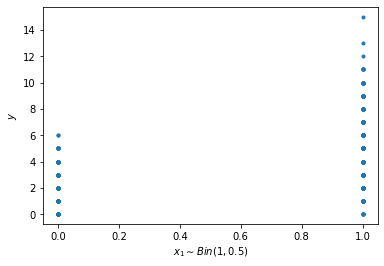

In [4]:
plt.plot(x1,y,'.')
plt.ylabel('$y$')
plt.xlabel('$x_{1} \sim Bin(1,0.5$)')
plt.show()

 __NB__: The larger the choice of $\beta_{1}$, the more $x_{1}$ will classify the data. A little overlap is left by this choice of $\beta_{1}$ so that the posterior predictive probability $p$ is less than one. Complete overlap would result in a toss-up of $p \approx 0.5$

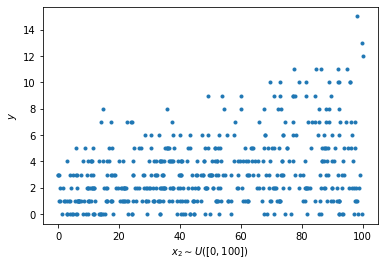

In [5]:
plt.plot(x2,y,'.')
plt.ylabel('$y$')
plt.xlabel('$x_{2} \sim U([0,100])$')
plt.show()

$x_2$ predicts some increase in the count response variable.

# MCMC Poisson Regression

In [6]:
observations = y

In [7]:
with pm.Model() as MCMC_model:
    # Create the beta parameters
    b0 = pm.Normal('b0', mu=0, sigma=10)
    b1 = pm.Normal('b1', mu=0, sigma=10)
    b2 = pm.Normal('b2', mu=0, sigma=1)
    

    # define linear model and exp link function
    theta = (b0 + b1 * x1 + b2 * x2)

    ## Define Poisson likelihood
    obs = pm.Poisson('y', mu=np.exp(theta), observed=observations)
    
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    model_trace = pm.sample(N_SAMPLES, step=step);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [b2]
>Metropolis: [b1]
>Metropolis: [b0]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 4339.77draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


# Posterior Distributions for the Betas

In [8]:
b0_samples = model_trace["b0"][N_SAMPLES:, None]
b1_samples = model_trace["b1"][N_SAMPLES:, None]
b2_samples = model_trace["b2"][N_SAMPLES:, None]

Text(0, 0.5, 'Probability Density')

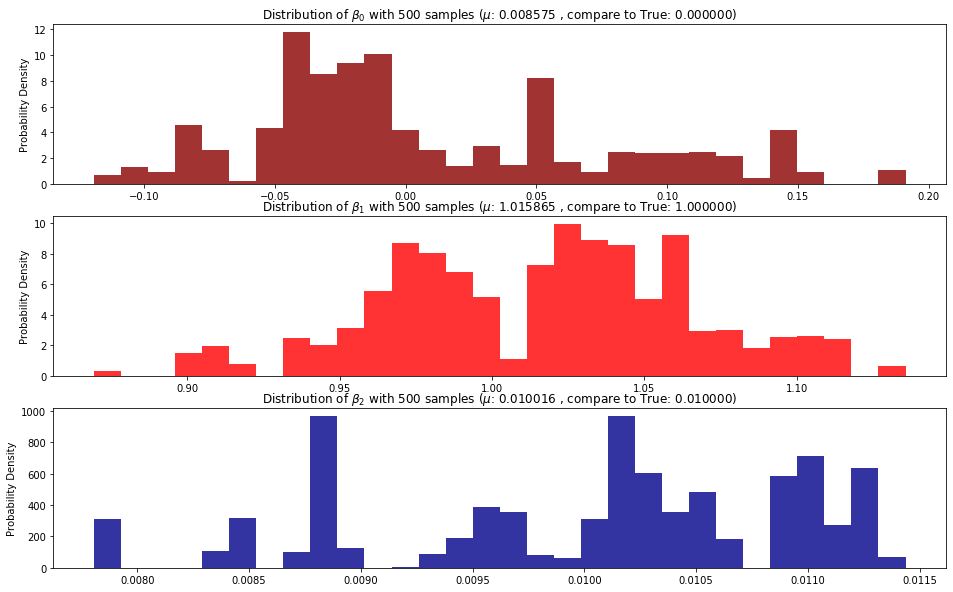

In [9]:
figsize(16, 10)

plt.subplot(311)
plt.title(r"""Distribution of $\beta_0$ with %d samples ($\mu$: %f , compare to True: %f)""" % (N_SAMPLES,b0_samples.mean(), betas[0]))

plt.hist(b0_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(312)
plt.title(r"""Distribution of $\beta_1$ with %d samples ($\mu$: %f , compare to True: %f)""" % (N_SAMPLES,b1_samples.mean(),betas[1]))

plt.hist(b1_samples, histtype='stepfilled', 
         color = 'red', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')

plt.subplot(313)
plt.title(r"""Distribution of $\beta_2$ with %d samples ($\mu$: %f , compare to True: %f)""" % (N_SAMPLES,b2_samples.mean(),betas[2]))

plt.hist(b2_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')

# Posterior Predictive Distributions



Question: what is $p(y_{2} > y_{1} | \mathbf{x}_{1} = [0,x_{1}] \text{ and } \mathbf{x}_{2} = [1,x_{1}]  )$?



First generate the posterior predictive distributions by taking the MC distributions of the $\beta$'s and getting a distribution of $\lambda$'s. Use two test points in $x$-space to generate these (__shouldn't we integrate over all marginal points as opposed to just having two?__):

In [10]:
point_1 = np.array([0,0])
point_2 = np.array([1,0])

log_lambdas_predictive_1 = b0_samples + point_1[0]*b1_samples + point_1[1]*b2_samples
log_lambdas_predictive_2 = b0_samples + point_2[0]*b1_samples + point_2[1]*b2_samples

### Density of lambdas:

Text(0, 0.5, 'Probability Density')

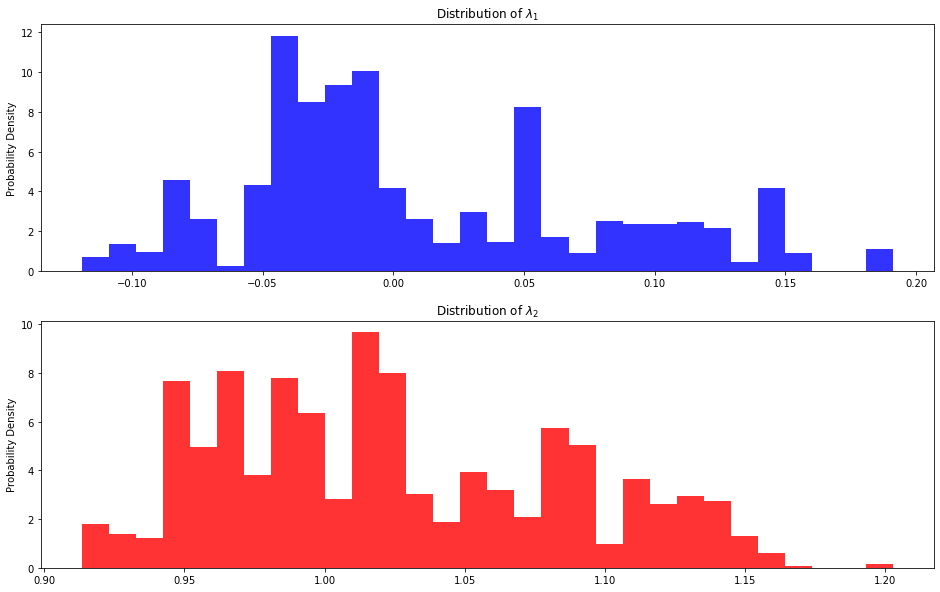

In [11]:
figsize(16, 10)

plt.subplot(211)
plt.title(r"Distribution of $\lambda_1$")

plt.hist(log_lambdas_predictive_1, histtype='stepfilled', 
         color = 'blue', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.title(r"Distribution of $\lambda_2$")

plt.hist(log_lambdas_predictive_2, histtype='stepfilled', 
         color = 'red', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')

### Generation of Posterior Predictive Distributions

Using the distribution of parameter (i.e. $\lambda$) values, draw from $Pois(\lambda)$ for over that $\lambda$ distribution. 

In [12]:
y_1 = np.random.poisson(np.exp(log_lambdas_predictive_1))
y_2 = np.random.poisson(np.exp(log_lambdas_predictive_2))

###  Posterior Predictive Probabilility

Now tht we have draws for $y_1$ and $y_2$, use an indicator function $I(y_2>y_1)$to find the posterior predictive probability. Remeber that the indicator function integrates over the samples, which is the same as doing an elementwise boolean operation as below. 

In [13]:
print("Posterior probability: ",np.mean(y_2 > y_1))

Posterior probability:  0.7493333333333333
